In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


**The same processing, with PCA Analysis** and keeping the N most 'important' PCA components for every model

In [ ]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.svm import SVC
from sklearn.neural_network import MLPClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix
from sklearn.inspection import permutation_importance

In [ ]:
# Load and Prepare Data
csv_file = '/content/drive/MyDrive/processed_data_trig_angles.csv'
data = pd.read_csv(csv_file)

# Remove magnitude columns (if they are there) and keep only phase information (sin and cos)
phase_columns = [col for col in data.columns if 'Sin' in col or 'Cos' in col]
X = data[phase_columns]
y = data['Label'].apply(lambda x: 0 if x == 'air' else 1)  # Encoding 'air' as 0 and 'water' as 1

# Split the data into training+validation and test sets
X_train_val, X_test, y_train_val, y_test = train_test_split(X, y, test_size=0.15, random_state=42)

# Split the training+validation set into training and validation sets
X_train, X_val, y_train, y_val = train_test_split(X_train_val, y_train_val, test_size=0.1765, random_state=42)  # 0.1765 of 85% is about 15% of the total

# Standardize the features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_val_scaled = scaler.transform(X_val)
X_test_scaled = scaler.transform(X_test)

# Print the number of initial components
print(f"Number of initial features: {X_train_scaled.shape[1]}")



Number of initial features: 136


In [ ]:
# Apply PCA
pca = PCA(n_components=0.95)  # Retain 95% of variance
X_train_pca = pca.fit_transform(X_train_scaled)
X_val_pca = pca.transform(X_val_scaled)
X_test_pca = pca.transform(X_test_scaled)

# Print the number of components after PCA
print(f"Number of components after PCA: {X_train_pca.shape[1]}")



Number of components after PCA: 72


In [ ]:
# Define and Train Simplified Models
models = {
    'Logistic Regression': LogisticRegression(random_state=42),
    'Random Forest': RandomForestClassifier(max_depth=5, n_estimators=30, random_state=42),
    'SVM': SVC(kernel='linear', random_state=42),
    'Gradient Boosting': GradientBoostingClassifier(max_depth=3, n_estimators=50, random_state=42),
    'MLP': MLPClassifier(hidden_layer_sizes=(50,), max_iter=500, random_state=42),
    'Naive Bayes': GaussianNB()
}

# parameter for top features number
top_n_features = 15

# Train and evaluate models
results = {}
for name, model in models.items():
    # Train on full training set
    model.fit(X_train_pca, y_train)

    # Calculate permutation importance using validation set
    perm_importance = permutation_importance(model, X_val_pca, y_val, n_repeats=10, random_state=42)

    # Get indices of top N features
    top_indices = perm_importance.importances_mean.argsort()[-top_n_features:][::-1]

    # Keep only top N features
    X_train_top = X_train_pca[:, top_indices]
    X_val_top = X_val_pca[:, top_indices]
    X_test_top = X_test_pca[:, top_indices]

    # Train on full training set with top features
    model.fit(X_train_top, y_train)

    # Evaluate on validation set
    val_pred = model.predict(X_val_top)
    val_accuracy = accuracy_score(y_val, val_pred)

    # Predict on test set
    y_pred = model.predict(X_test_top)
    test_accuracy = accuracy_score(y_test, y_pred)

    # Generate classification report
    report = classification_report(y_test, y_pred, target_names=['air', 'water'], output_dict=True)

    # Generate confusion matrix
    conf_matrix = confusion_matrix(y_test, y_pred)

    results[name] = {
        'Validation Accuracy': val_accuracy,
        'Test Accuracy': test_accuracy,
        'Classification Report': report,
        'Confusion Matrix': conf_matrix,
        'Permutation Importance': perm_importance,
        'Top Feature Indices': top_indices,
        'True Labels': y_test,
        'Predicted Labels': y_pred
    }


/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(



Logistic Regression:
Validation Accuracy: 0.5097
Test Accuracy: 0.4825
Classification Report:
              precision    recall  f1-score   support

         air       0.53      0.33      0.40       138
       water       0.46      0.66      0.54       119

    accuracy                           0.48       257
   macro avg       0.49      0.49      0.47       257
weighted avg       0.50      0.48      0.47       257



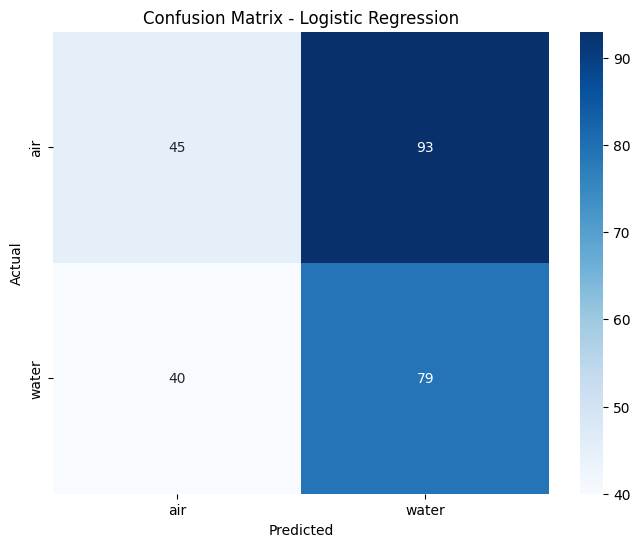

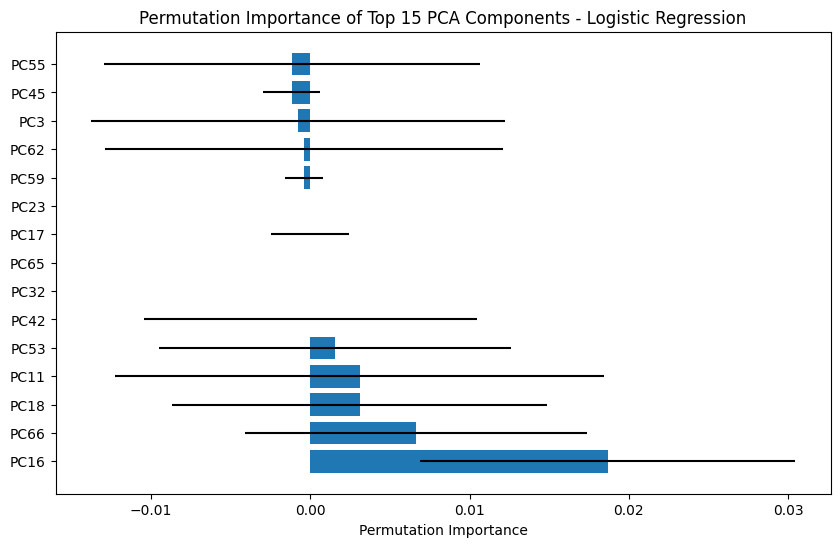


Random Forest:
Validation Accuracy: 0.7704
Test Accuracy: 0.7665
Classification Report:
              precision    recall  f1-score   support

         air       0.85      0.69      0.76       138
       water       0.70      0.86      0.77       119

    accuracy                           0.77       257
   macro avg       0.78      0.77      0.77       257
weighted avg       0.78      0.77      0.77       257



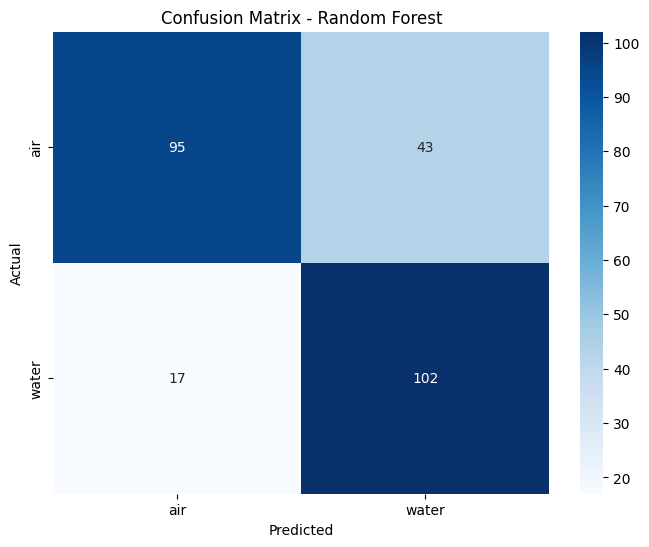

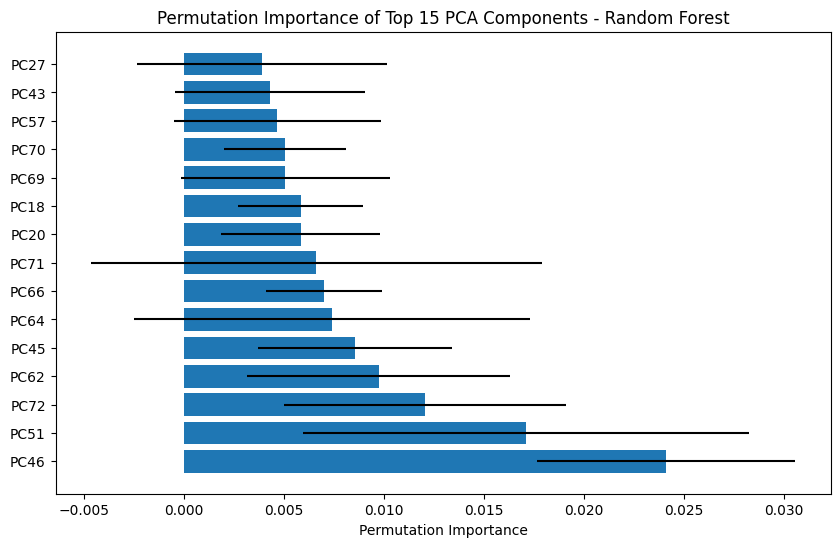


SVM:
Validation Accuracy: 0.5136
Test Accuracy: 0.4630
Classification Report:
              precision    recall  f1-score   support

         air       0.50      0.31      0.38       138
       water       0.44      0.64      0.52       119

    accuracy                           0.46       257
   macro avg       0.47      0.48      0.45       257
weighted avg       0.47      0.46      0.45       257



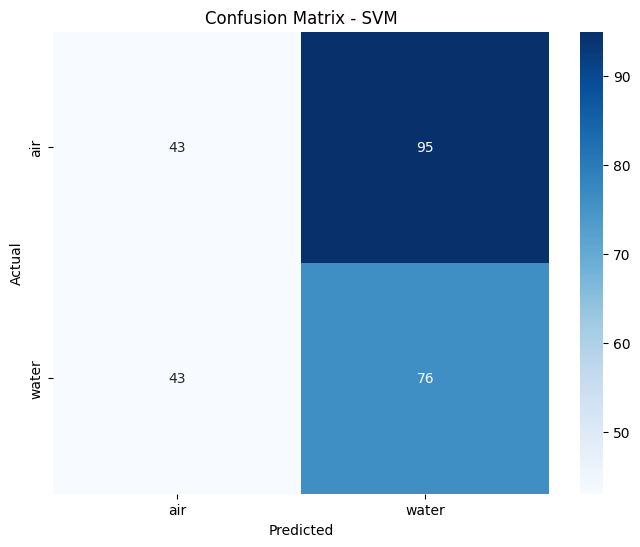

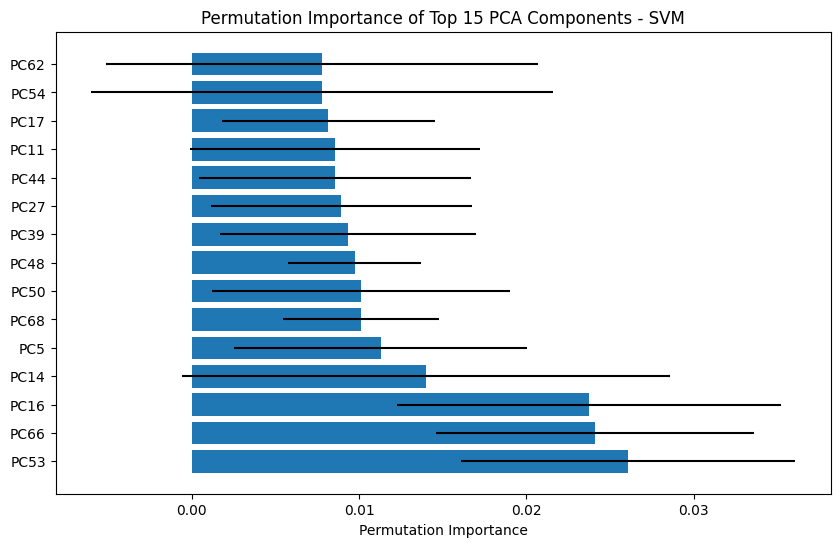


Gradient Boosting:
Validation Accuracy: 0.7860
Test Accuracy: 0.7160
Classification Report:
              precision    recall  f1-score   support

         air       0.76      0.68      0.72       138
       water       0.67      0.76      0.71       119

    accuracy                           0.72       257
   macro avg       0.72      0.72      0.72       257
weighted avg       0.72      0.72      0.72       257



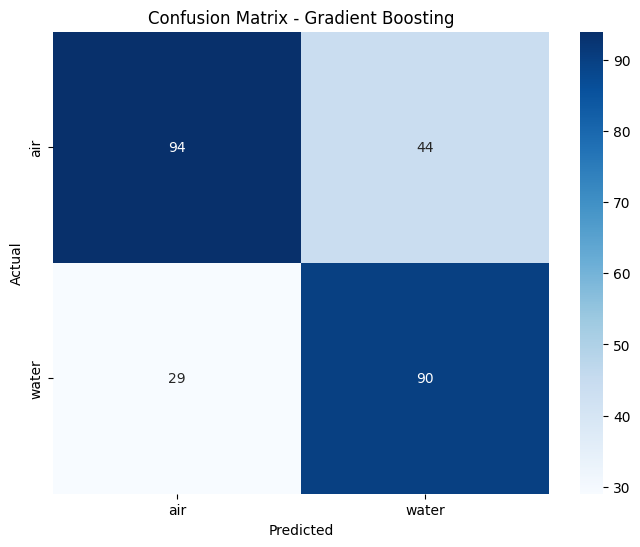

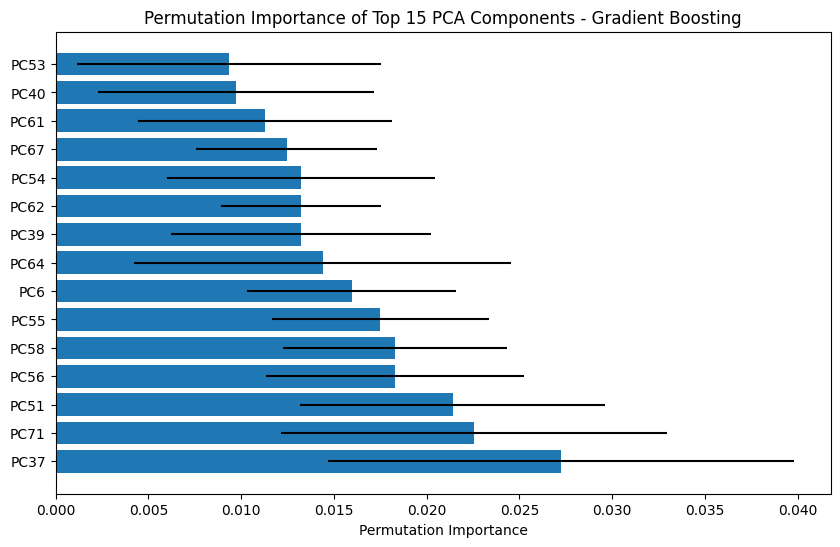


MLP:
Validation Accuracy: 0.7782
Test Accuracy: 0.8132
Classification Report:
              precision    recall  f1-score   support

         air       0.87      0.77      0.82       138
       water       0.76      0.87      0.81       119

    accuracy                           0.81       257
   macro avg       0.82      0.82      0.81       257
weighted avg       0.82      0.81      0.81       257



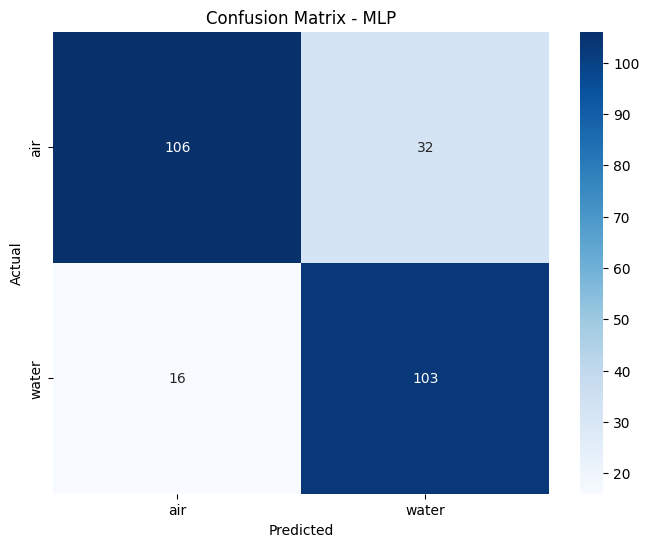

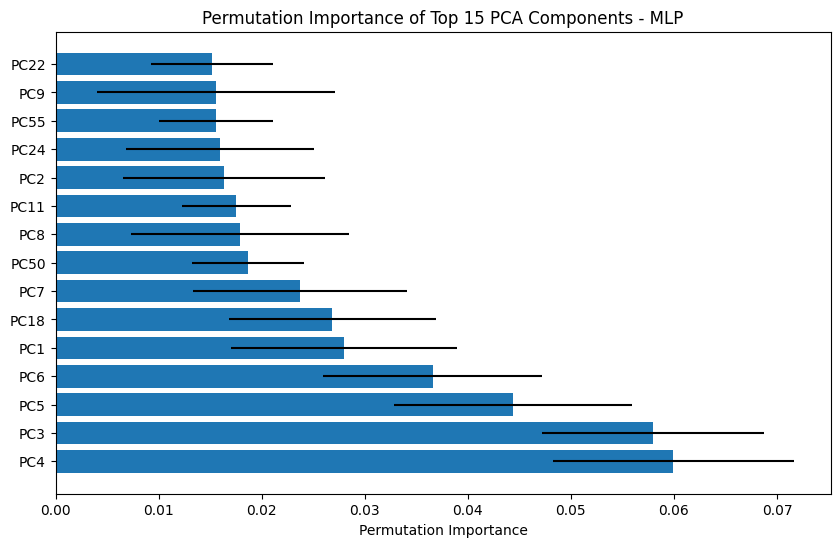


Naive Bayes:
Validation Accuracy: 0.8210
Test Accuracy: 0.7821
Classification Report:
              precision    recall  f1-score   support

         air       0.85      0.72      0.78       138
       water       0.72      0.86      0.78       119

    accuracy                           0.78       257
   macro avg       0.79      0.79      0.78       257
weighted avg       0.79      0.78      0.78       257



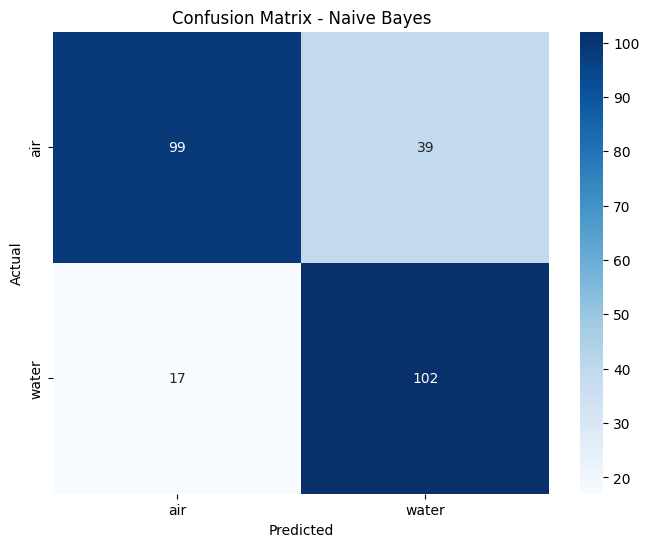

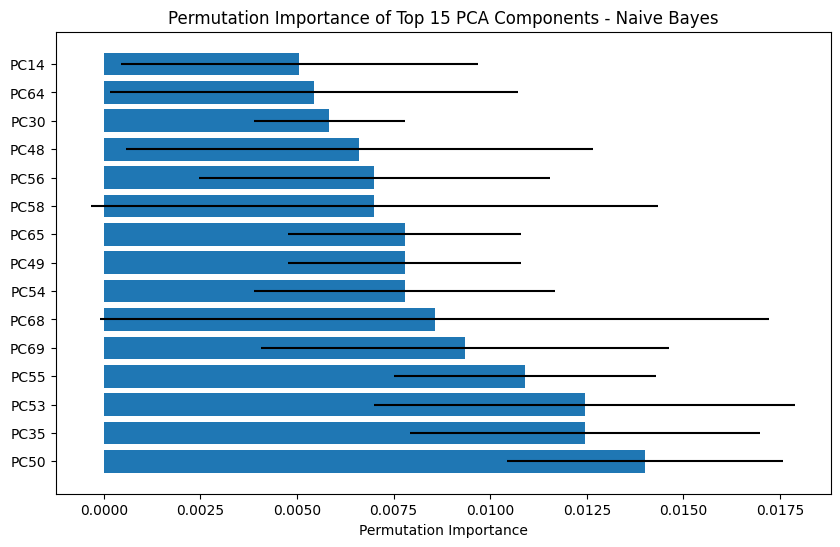


Final Results for All Models:
                 Model  Validation Accuracy  Test Accuracy  Precision (air)  \
0  Logistic Regression             0.509728       0.482490         0.529412   
1        Random Forest             0.770428       0.766537         0.848214   
2                  SVM             0.513619       0.463035         0.500000   
3    Gradient Boosting             0.785992       0.715953         0.764228   
4                  MLP             0.778210       0.813230         0.868852   
5          Naive Bayes             0.821012       0.782101         0.853448   

   Recall (air)  F1 Score (air)  
0      0.326087        0.403587  
1      0.688406        0.760000  
2      0.311594        0.383929  
3      0.681159        0.720307  
4      0.768116        0.815385  
5      0.717391        0.779528  


In [ ]:

# Print Results and Plot Confusion Matrices
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import classification_report

# Initialize an empty list to collect results
final_results = []

# Iterate over results and print metrics, plot graphs, and collect data
for name, result in results.items():
    # Print results
    print(f"\n{name}:")
    print(f"Validation Accuracy: {result['Validation Accuracy']:.4f}")
    print(f"Test Accuracy: {result['Test Accuracy']:.4f}")
    print("Classification Report:")
    print(classification_report(result['True Labels'], result['Predicted Labels'], target_names=['air', 'water']))

    # Append results to final_results list
    report = result['Classification Report']
    final_results.append({
        'Model': name,
        'Validation Accuracy': result['Validation Accuracy'],
        'Test Accuracy': result['Test Accuracy'],
        'Precision (air)': report['air']['precision'],
        'Recall (air)': report['air']['recall'],
        'F1 Score (air)': report['air']['f1-score']
    })

    # Plot confusion matrix
    plt.figure(figsize=(8, 6))
    sns.heatmap(result['Confusion Matrix'], annot=True, fmt='d', cmap='Blues',
                xticklabels=['air', 'water'], yticklabels=['air', 'water'])
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.title(f'Confusion Matrix - {name}')
    plt.show()

    # Plot permutation importance for top features
    importance = result['Permutation Importance']
    top_indices = result['Top Feature Indices']
    plt.figure(figsize=(10, 6))
    plt.barh(range(len(top_indices)), importance.importances_mean[top_indices],
             xerr=importance.importances_std[top_indices])
    plt.yticks(range(len(top_indices)), [f'PC{i+1}' for i in top_indices])
    plt.xlabel('Permutation Importance')
    plt.title(f'Permutation Importance of Top {top_n_features} PCA Components - {name}')
    plt.show()

# Convert the list to a DataFrame and display it
final_results_df = pd.DataFrame(final_results)
print("\nFinal Results for All Models:")
print(final_results_df)


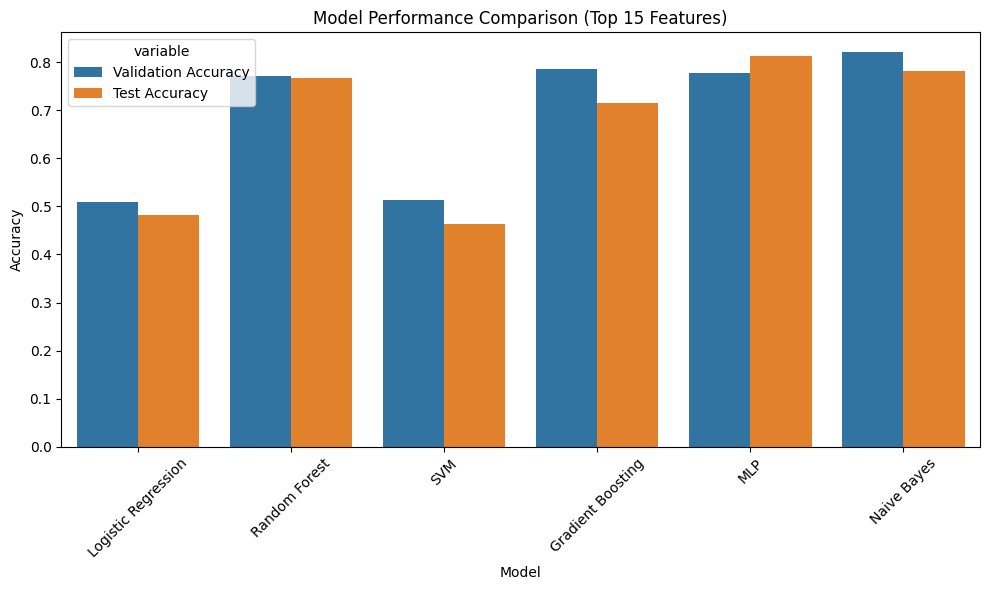

In [ ]:

# Compare Model Performances
performance_df = pd.DataFrame({
    'Model': results.keys(),
    'Validation Accuracy': [result['Validation Accuracy'] for result in results.values()],
    'Test Accuracy': [result['Test Accuracy'] for result in results.values()]
})

plt.figure(figsize=(10, 6))
sns.barplot(x='Model', y='value', hue='variable',
            data=pd.melt(performance_df, ['Model'], ['Validation Accuracy', 'Test Accuracy']))
plt.title(f'Model Performance Comparison (Top {top_n_features} Features)')
plt.ylabel('Accuracy')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


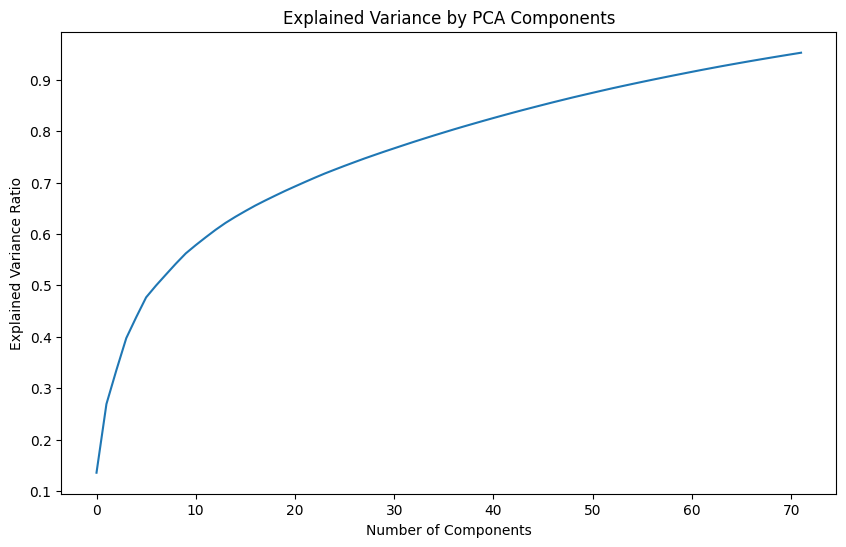

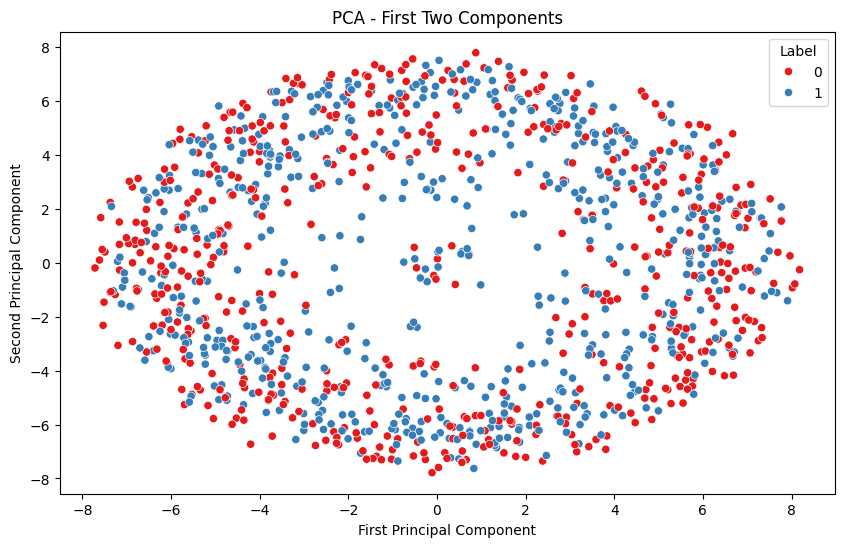

In [ ]:

# Visualize PCA Components
# Plot explained variance ratio
plt.figure(figsize=(10, 6))
plt.plot(np.cumsum(pca.explained_variance_ratio_))
plt.xlabel('Number of Components')
plt.ylabel('Explained Variance Ratio')
plt.title('Explained Variance by PCA Components')
plt.show()

# Plot first two PCA components
plt.figure(figsize=(10, 6))
sns.scatterplot(x=X_train_pca[:, 0], y=X_train_pca[:, 1], hue=y_train, palette='Set1')
plt.xlabel('First Principal Component')
plt.ylabel('Second Principal Component')
plt.title('PCA - First Two Components')
plt.show()


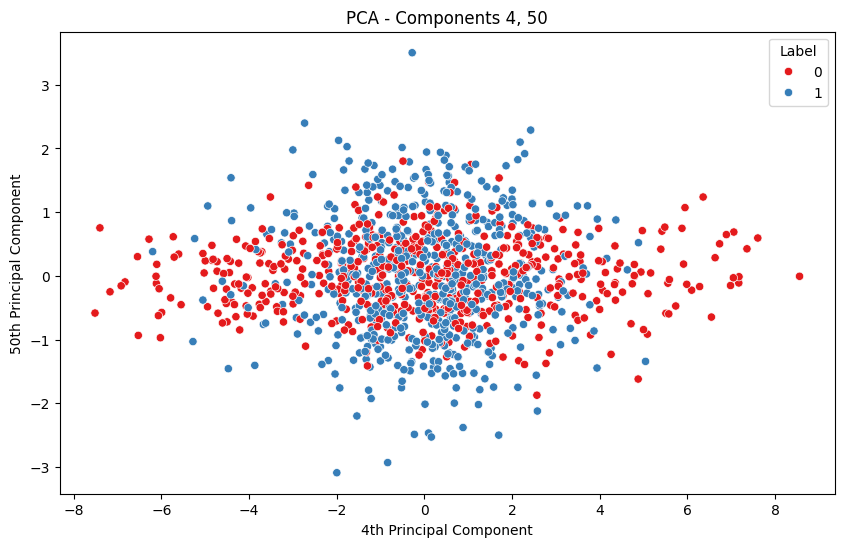

In [ ]:
# Plot two PCA components
plt.figure(figsize=(10, 6))
sns.scatterplot(x=X_train_pca[:, 4], y=X_train_pca[:, 50], hue=y_train, palette='Set1')
plt.xlabel('4th Principal Component')
plt.ylabel('50th Principal Component')
plt.title('PCA - Components 4, 50')
plt.show()


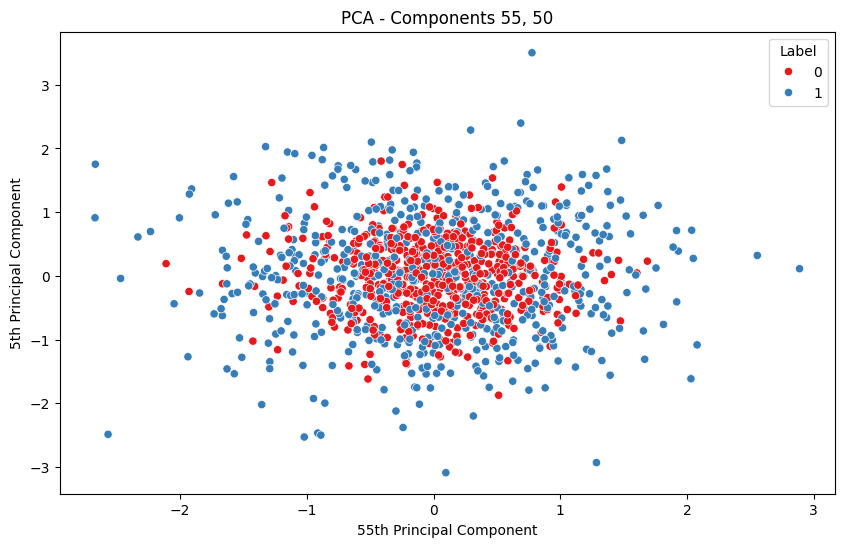

In [ ]:
# Plot two PCA components
plt.figure(figsize=(10, 6))
sns.scatterplot(x=X_train_pca[:, 55], y=X_train_pca[:, 50], hue=y_train, palette='Set1')
plt.xlabel('55th Principal Component')
plt.ylabel('5th Principal Component')
plt.title('PCA - Components 55, 50')
plt.show()
